This is the main notebook where we will redistrict Iowa.

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from PIL import Image, ImageOps
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label, 
                      ggtitle, element_blank, element_rect, 
                      scale_fill_manual, theme_minimal, theme) 
from pulp import (LpProblem, LpMinimize, LpVariable, lpSum, 
                  PULP_CBC_CMD, GLPK_CMD, LpStatus, value) 

# Prepping the census and geopandas dataframes

In [2]:
df=pd.read_csv('census.csv')
df.head()

,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,Adair,7496,1,41.328528,-94.478164
1,1,Adams,3704,3,41.021656,-94.696906
2,2,Allamakee,14061,5,43.274964,-91.382751
3,3,Appanoose,12317,7,40.744683,-92.870345
4,4,Audubon,5674,9,41.679178,-94.904312


In [3]:
df['COUNTYFP10']=df['COUNTYFP10'].astype(str).str.pad(3,fillchar='0')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   county_id   99 non-null     int64  
 1   county      99 non-null     object 
 2   population  99 non-null     int64  
 3   COUNTYFP10  99 non-null     object 
 4   latitude    99 non-null     float64
 5   longitude   99 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 4.8+ KB


In [5]:
#imports county shapefiles from MGGG
shapefile_iowa = gpd.read_file('IA_counties/IA_counties.shp')
shapefile_iowa.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,TOTVOT12,PRES12D,PRES12R,PRES12OTH,TOTVOT16,PRES16D,PRES16R,PRES16OTH,CD,geometry
0,19,127,19127,Marshall,Marshall County,1482770678,1803086,+42.0416910,-092.9814523,40648,...,19064,10257,8472,335,17980,7652,9146,1182,1,"POLYGON ((-92.76679 42.12346, -92.76679 42.122..."
1,19,011,19011,Benton,Benton County,1855117342,5760770,+42.0925474,-092.0576300,26076,...,14023,6862,6940,221,13844,4678,8232,934,1,"POLYGON ((-91.94773 41.86186, -91.95514 41.861..."
2,19,041,19041,Clay,Clay County,1469139214,13866941,+43.0798220,-095.1497261,16667,...,8502,3385,4951,166,8617,2249,5877,491,4,"POLYGON ((-95.26926 43.25537, -95.26140 43.255..."
3,19,165,19165,Shelby,Shelby County,1530110414,1486135,+41.6790143,-095.3089173,12167,...,6483,2469,3911,103,6370,1662,4362,346,4,"POLYGON ((-95.20902 41.86371, -95.20890 41.863..."
4,19,043,19043,Clayton,Clayton County,2016405612,36586071,+42.8409979,-091.3235108,18129,...,9138,4806,4164,168,9129,3237,5317,575,1,"POLYGON ((-91.25080 42.64558, -91.25160 42.645..."


# Merging pd and gpd dataframes and creating population heat map

## Prepping the data

In [6]:
map_population_by_county_data = shapefile_iowa.merge(df, on='COUNTYFP10')
county_populations = np.array(df['population'])
state_population = sum(county_populations)
df.sort_values('population', ascending=False).head()

,county_id,county,population,COUNTYFP10,latitude,longitude
76,76,Polk,492401,153,41.684281,-93.569720
56,56,Linn,230299,113,42.077951,-91.597673
81,81,Scott,174669,163,41.641679,-90.622290
51,51,Johnson,152854,103,41.668737,-91.588812
6,6,Black Hawk,131144,013,42.472888,-92.306059


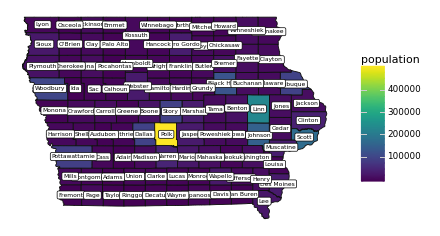

<ggplot: (334855232)>

In [7]:
map_population_by_county = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='NAME10',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_population_by_county

## Population heat map for Iowa

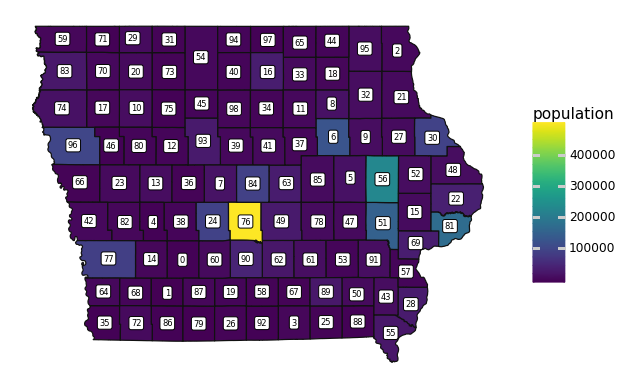

<ggplot: (334972823)>

In [8]:
map_by_county_id = (
    ggplot(map_population_by_county_data)
    + geom_map(aes(fill='population'))
    + geom_label(aes(x='longitude', y='latitude', 
                     label='county_id',size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank()
           )
    )
map_by_county_id

# Analysis of county sizes in Iowa and Oregon

## Importing Oregon information

In [9]:
or_census=pd.read_csv('oregon_redistricting/oregon_census.csv')

In [10]:
or_census.head()

,County_ID,County_Name,Population2020e,Population2010,Latitude,Longitude,Change2010_2020
0,0,Baker,16910,16134,44.7346,-117.6777,776
1,1,Benton,94665,85579,44.4929,-123.3844,9086
2,2,Clackamas,426515,375992,45.3088,-122.3999,50523
3,3,Clatsop,39455,37039,46.1068,-123.8773,2416
4,4,Columbia,53280,49351,45.9189,-122.9863,3929


## Boxplots and swarmplots for county populations

<AxesSubplot:xlabel='Population2020e'>

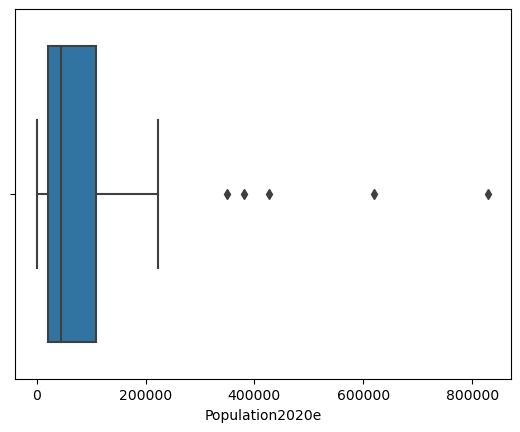

In [11]:
sns.boxplot(x=or_census['Population2020e'])

<AxesSubplot:xlabel='population'>

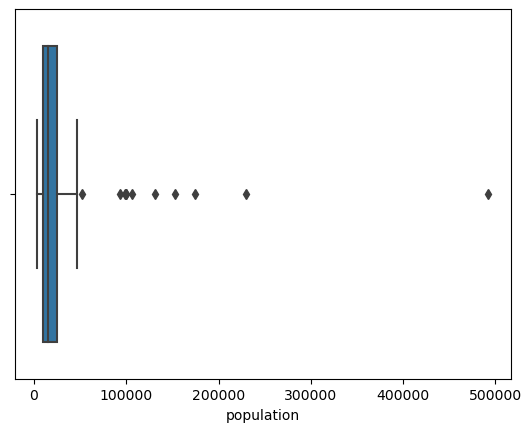

In [12]:
sns.boxplot(x=df['population'])

In [13]:
ia_array = df['population'].to_numpy()
or_array= or_census['Population2020e'].to_numpy()

In [14]:
pops=np.concatenate((ia_array, or_array),axis=0)

In [15]:
states=np.concatenate((np.array(['Iowa']*99), np.array(['Oregon']*36)),axis=0)


In [16]:
pop_df = pd.DataFrame({"state": states, "population": pops})

In [17]:
pop_df.head()

,state,population
0,Iowa,7496
1,Iowa,3704
2,Iowa,14061
3,Iowa,12317
4,Iowa,5674


<AxesSubplot:xlabel='population', ylabel='state'>

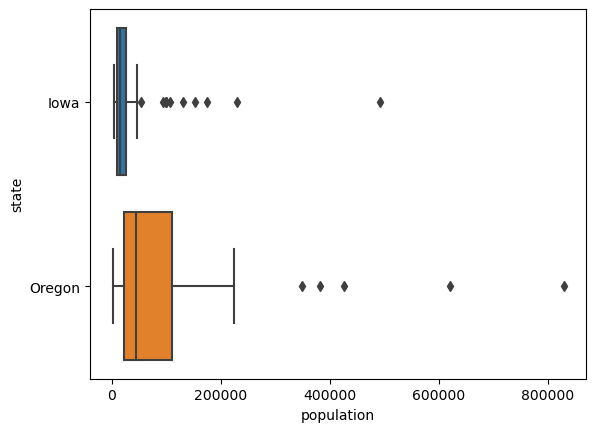

In [18]:
sns.boxplot(data=pop_df, x='population',y='state')

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.10/site-packages/seaborn/categorical.py:1296: UserWarning: 41.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


<AxesSubplot:xlabel='state', ylabel='population'>

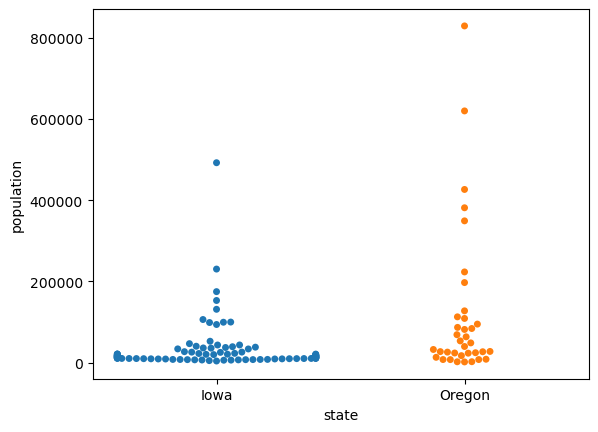

In [19]:
sns.swarmplot(data=pop_df, y='population',x='state')

<AxesSubplot:xlabel='population', ylabel='Count'>

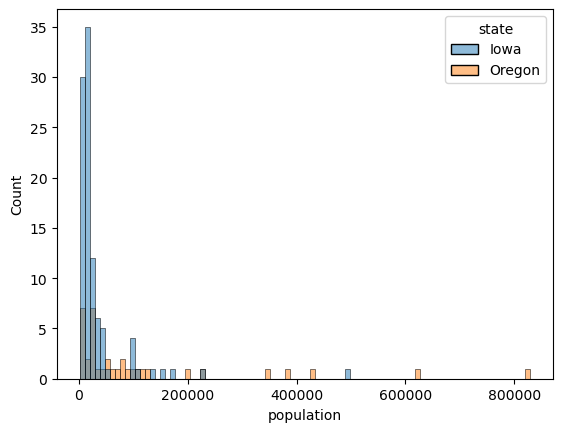

In [20]:
sns.histplot(data=pop_df, x='population', hue='state',bins=90)

# Creating the adjacency matrix for Iowa counties

In [96]:
# full statewide adjacency matrix (first boolean, then casting as int)
#   NOTE: this operation counts a county as adjacent to itself. subtract eye(99) to get a more traditional version
#   also should do this operation after any sorting of the original shapefile

n_counties = 99

ia_adjac_matrix = pd.DataFrame()

for j in range(n_counties):
    ia_adjac_matrix[j] = shapefile_iowa.intersects(shapefile_iowa.iloc[[j]].unary_union)
ia_adjac_matrix = ia_adjac_matrix - np.identity(99)
ia_adjac_matrix = ia_adjac_matrix.astype(int)

ia_adjac_matrix_bool = ia_adjac_matrix.astype(bool)



In [97]:
# first row of the full adjacency matrix is for Marshall County (since it is indexed first in original shapefile_iowa)
ia_adjac_matrix[[0]]

,0
0,0
1,0
2,0
3,0
4,0
...,...
94,0
95,1
96,1
97,0


In [71]:
# vector of counties which border county 0 (Marshall)
marshall_boolean = ia_adjac_matrix[[0]] == 1

# pulling corresponding rows from original shapefile df:
shapefile_iowa.loc[marshall_boolean.values, ['GEOID10','COUNTYFP10','NAME10','INTPTLAT10', 'INTPTLON10', 'geometry' ]]

,GEOID10,COUNTYFP10,NAME10,INTPTLAT10,INTPTLON10,geometry
54,19099,099,Jasper,+41.6856863,-093.0529712,"POLYGON ((-92.76643 41.68812, -92.76643 41.686..."
63,19083,083,Hardin,+42.3899554,-093.2410810,"POLYGON ((-93.14458 42.55674, -93.14373 42.556..."
83,19171,171,Tama,+42.0748481,-092.5294115,"POLYGON ((-92.76631 42.03504, -92.76632 42.036..."
86,19157,157,Poweshiek,+41.6845262,-092.5228819,"POLYGON ((-92.41560 41.86251, -92.41028 41.862..."
95,19169,169,Story,+42.0375379,-093.4660934,"POLYGON ((-93.58088 41.86322, -93.58091 41.863..."
96,19075,075,Grundy,+42.4033232,-092.7902613,"POLYGON ((-93.00290 42.47064, -93.00393 42.470..."


# Optimization Model

In [41]:
zp_county=np.array((df['county_id']+1).astype(str).str.pad(2,fillchar='0'))

In [42]:
zp_county

array(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
       '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22',
       '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33',
       '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44',
       '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55',
       '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66',
       '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77',
       '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88',
       '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99'],
      dtype=object)

In [150]:
n_districts = 4

# Create the linear programming model.
model = LpProblem("Supply-Demand-Problem", LpMinimize) 
variable_names = [str(i)+str(j) for j in range(1, n_districts+1) 
                                for i in range(1, n_counties+1)]
# variable_names = [zp_county[i]+str(j) for j in range(1, n_districts+1) \
#                                 for i in range(n_counties)]
variable_names.sort() 

# The Decision Variable is 1 if the county is assigned to the district.
DV_variable_y = LpVariable.matrix("Y", variable_names, cat="Binary")
assignment = np.array(DV_variable_y).reshape(n_counties,n_districts)

# # The Decision Variable is the population allocated to the district.
DV_variable_x = LpVariable.matrix("X", variable_names, cat="Integer",
                                  lowBound=0)
allocation = np.array(DV_variable_x).reshape(n_counties,n_districts)

In [151]:
# This objective minimizes the counties split among multiple districts.
objective_function = lpSum(assignment) 
model += objective_function

In [145]:
ideal_district_size=state_population/n_districts
district_maximum=int(ideal_district_size*1.01)
district_minimum=int(ideal_district_size*.99)
print()

789616


In [154]:
# Initial Assignment / Allocation Constraints

# Allocate 100% of the population from each county.
for i in range(n_counties):
    model += lpSum(allocation[i][j] for j in range(n_districts)) == county_populations[i] , "Allocate All " + str(i)

# This constraint makes assignment required for allocation.
# sum(county_populations) is the "big M"
for i in range(n_counties): 
    for j in range(n_districts):
        model += allocation[i][j] <= sum(county_populations)*assignment[i][j] , "Allocation assignment " + str(i) + str(j)

#numpy documentation for np array
#https://numpy.org/doc/stable/glossary.html#term-row-major
# Contiguous districts constraints
for j in range(n_districts):
    temp_assignment = assignment[:,j]
    for k in range(n_counties):
        current_boolean = ia_adjac_matrix[[k]]
        model += assignment[k][j] <= sum(temp_assignment[ia_adjac_matrix_bool[k]])
    
# District size constraints, in order to keep the size of districts by population similar
for j in range(n_districts):
    model += lpSum(allocation[i][j] for i in range(n_counties)) <= district_maximum , "District Size Maximum " + str(j)
    model += lpSum(allocation[i][j] for i in range(n_counties)) >= district_minimum , "District Size Minimum " + str(j)

# Only allow counties that meet certain critera to be split among multiple districts
# A county must have population > 220,000 to be split among up to two districts
# for i in range(n_counties): # added
#     if county_populations[i] <= 220000: 
#         model += lpSum(assignment[i][j] for j in range(n_districts)) <= 1  , "Unique Assignment " + str(i) 
#     else:
#         model += lpSum(assignment[i][j] for j in range(n_districts)) <= 2  , "Up-to-two Assignments " + str(i)

PulpError: overlapping constraint names: Allocate_All_0